<a href="https://colab.research.google.com/github/mivantec/Ivantechenko_BIX_F21/blob/main/MI_Homework2_accumulation_of_evidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2 - Evidence Accumulation

This homework has two main parts:

- First, we will build off the lab by exploring the relationship between decision threshold (one of the DDM parameters) and the performance of an accumulating agent.
- Second, we will take a brief look at the role of randomness in the exploratory behavior of a sniffing agent.

## Section - Setup

### Install explorationlib, import modules, configure notebook

In [3]:
# ADMCode uses an old version of numba
!pip install numba==0.48
!pip install --upgrade git+https://github.com/clappm/AdaptiveDecisionMaking_2018

!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

from __future__ import division
from ADMCode import visualize as vis
from ADMCode import ddm, sdt

import numpy as np
import pandas as pd

from ipywidgets import interactive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientDiffusionDiscrete
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import TruncatedLevyDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death

# Pretty plots
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
sns.set(style='white', font_scale=1.3)

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 20.2 MB 1.3 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Cloning https://github.com/clappm/AdaptiveDecisionMaking_2018 to /tmp/pip-req-build-5759o747
  Running command git clone -q https://github.com/clappm/AdaptiveDecisionMaking_2018 /tmp/pip-req-build-5759o747
  Created wheel for ADMCode: filename=ADMCode-0.5.2-py3-none-any.whl size=39223 sha256=6d09ca33b04984ad031da452517b0dc93d7d3cb80690147230e08e5464447572
  Stored in directory: /tmp/pip-ephem-wheel-cache-8p0c1hdu/wheels/39/45/1c/971b7fac68419e436447919c986b425b87e4ab1ed2d33d9fa4
Successfully built ADMCode
  Cloning https://github.com/parenthetical-e/explorationli

/usr/local/lib/python3.7/dist-packages/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


pygame 2.0.2 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Section - Influence of Threshold on Performance [60 pts total]

How does decision thershold influence behavior? Here, we will perform a parameter sweep over the decision threshold to see how the agent is affected in a basic sniffing task.

For this section, you will need to slightly modify the lab code to loop over a list of thresholds rather than a list of drift rates.

### Define shared parameters and initialize environment [5 pts]

In [4]:
# Shared exp parameters
num_steps = 200
max_steps = 10
seed_value = 5838

min_length = 1
step_size = 0.1

noise_sigma = 2
detection_radius = 1
num_targets = 250 
target_boundary = (100, 100)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
coord, scent = create_grid_scent(target_boundary, amplitude=1, sigma=10)
scents = [scent for _ in range(len(targets))]
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

### Create a list of thresholds to test [5 pts]

Select at least 5 values.  For reference, the lab used a threshold of 3.

In [ ]:
# Our parameters (also changed from lab)
thresholds = [0.75, 1.5, 3.0, 4.5, 6.0]

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = thresholds # list(range(5))

### Run 100 experiments for each threshold [10 pts]

Use a drift rate of 1.0, the middle value from the lab.

In [ ]:
# Exp params
drift_rate = 1.0 #this used to be the threshold line if comparing w/ lab
accumulate_sigma = 1.0

num_experiments = 100

# Run
results = []
for i, threshold in zip(names, thresholds): #change this
    accum = AccumulatorGradientGrid(
        min_length=min_length, 
        max_steps=max_steps,  
        threshold=threshold,
        drift_rate=drift_rate,
        accumulate_sigma=accumulate_sigma
    )
    accum.seed(seed_value)
    # !
    exp = experiment(
        f"accum_{i}",
        accum,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=True,
        seed=seed_value
    )
    results.append(exp)

accum_0:   0%|          | 0/100 [00:00<?, ?it/s]

accum_1:   0%|          | 0/100 [00:00<?, ?it/s]

accum_3:   0%|          | 0/100 [00:00<?, ?it/s]

accum_4:   0%|          | 0/100 [00:00<?, ?it/s]

accum_6:   0%|          | 0/100 [00:00<?, ?it/s]

### Create plots of distance traveled, number of deaths, best score, and average score [10 pts]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

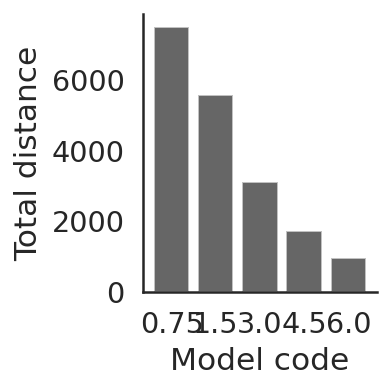

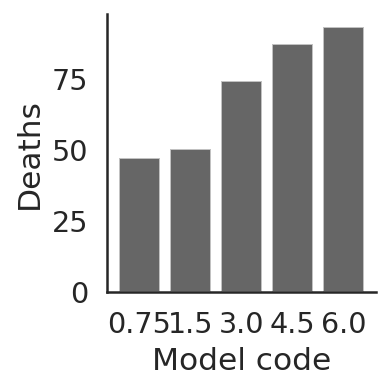

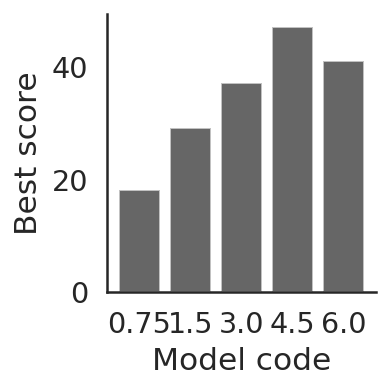

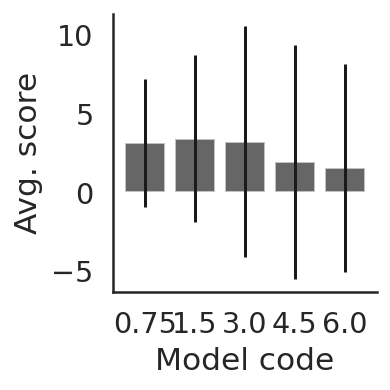

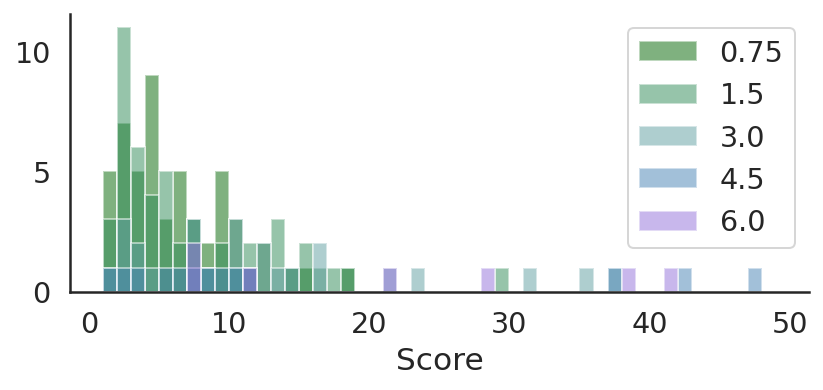

In [ ]:
# Scores
scores = []
for result in results:  
    l = 0.0
    for r in result:
        l += r["agent_total_l"][-1]
    scores.append(l)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total distance")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Score
scores = []
for result in results:
    scores.append(num_death(result))   

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Score
scores = []
for result in results:  
    r = total_reward(result)
    scores.append(r)   

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Model code")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Question 1 [15 pts]

Based on the plots above and in your own words, summarize the relationship between the decision _threshold_ and the total distance, number of deaths, best reward and average reward.  How do the effects of increasing threshold compare to the effects of increasing drift rate (from the example in lab)?

Increasing threshold of evidence needed to make a decision is related to less distance traveled, more deaths, and a lower average reward. The pattern for best score is less clear -- higher thresholds seem to trend toward a higher best score (which makes sense considering the agent is likely only acting when they are almost completely certain there is a reward/have accumulated a lot of evidence). The effects of increasing threshold on distance traveled and deaths are the opposite of those seen in the lab (in the lab, distance traveled increased while deaths decreased as result of increased drift rate). It is harder to compare for best score since the lab distribution was a little weird (1.0 had best score followed by 1.5 with 0.75 and 1.25 being the same). For average reward, the threshold effects were basically opposite the drift rate effects, with increasing drift rates seeming to result in higher average scores rather than lower. In summary, increasing the decision threshold resulted in the opposite effects as increasing the drift rate for the most part.

### Question 2 [10 pts]

Based on your observations, do you think an accumulator is needed for this *particular* task setup?  Would you expect an agent which doesn't accumulate (having a threshold of almost zero, thus reacting immediately to its first sensory signal) to outform an agent which uses multiple time steps to accumulate evidence?

I think it depends on what goal of the agent is (e.g., just to survive or to get the most rewards). If the goal is to survive like it seems to be in this task set up, you don't necessarily need an accumulator. Based on the simulation, lower thresholds for making decisions resulted in fewer deaths and not the lowest average score. However, if the threshold is almost zero, most decisions the agent is making will probably not lead to a reward/will result in reward being acquired basically due to random chance. Because of this, this kind of agent probably won't outform an agent which uses multiple time steps since the latter agent only makes a decision when it accumulates enough evidence in support of getting a reward as a result of that decision. This would result in a higher best score than a low threshold agent (as supported by the simulations). However, the multipe time steps agent comes with the drawback of increased chance of death, since sometimes it is waiting too long to accumulate evidence and get reward.

### Question 3 [5 pts]

Let's get philosophical. Is it better to gamble on being the best, knowing you risk death (in this task) or is it better to be average and alive? 

Based on the data from lab and this homework, what DDM parameters (drift rate, decision threshold) do you _personally_ prefer? There is no right answer. Be yourself.

The goal of this detached and impersonal virtual world is seemingly to survive (wish life's purpose was so clearcut), so the agent should aim to maximize its chance of survival by being average but alive. If the goal/purpose of the world were different, then maybe my answer would change, but it seems like the agent has nothing to gain through being better than average (it can't enjoy a higher best score if it is dead). Therefore, the agent should aim for average parameters for both -- for more specific numbers: drift rate of 1.0 actually resulted in highest best score and highest average score while being in the middle relative to the other agents with death rate; decision threshold of 1.5 since it was the 2nd lowest for deaths and 2nd highest average score based on simulations.

## Section - Is randomness still important for movement? [40 pts total]

Let's take a break from evidence accumulation to revisit the simpler sniffing agent, which automatically knows the gradient direction without having to decide first.

Recall that the movement of these sniffing agents is also governed by two other parameters: _p pos_ and _p neg_.  These represent the probability that the agent changes its direction before its linear movement.

- If the gradient is positive at the current location, then _p pos_ is the chance of changing direction.
- If the gradient is negative, then _p neg_ is the chance of changing direction.

### Question 4 [10 pts]
In the example in lab, _p pos_ was 0.5, and _p neg_ was 1.0. This means that when the gradient was positive half the time the walker would change direction anyway. It also means the all the time when the grad was negative, the explorer would change direction.

Do these parameter choices seem optimal to you? 

Make a best guess for how to improve them, if you think they can be improved. Explain your choice.

These parameter choices don't seem optimal or rather p pos doesn't. It doesn't make sense that if the scent gradient is positive, the agent would want to turn away from that. Instead, it should probably continue in that direction. The p neg parameter does make sense. If the scent gradient is negative, it is probably best to turn away from it and try a different direction instead of continuing along. I think decreasing p pos would increase the amount of reward the agent would obtain.

### Testing your hypothesis [15 pts]

By (very slightly) modifying the parameters of the code from lab, rerun the comparison between diffusion, levy, and sniffing agents, but with a better selection for _p pos_ and _p neg_.  Then plot the results.

test4_levy:   0%|          | 0/100 [00:00<?, ?it/s]

test4_diff:   0%|          | 0/100 [00:00<?, ?it/s]

test4_sniff:   0%|          | 0/100 [00:00<?, ?it/s]

Levy - 2.0
Diff - 0.0
Sniff - 72.0


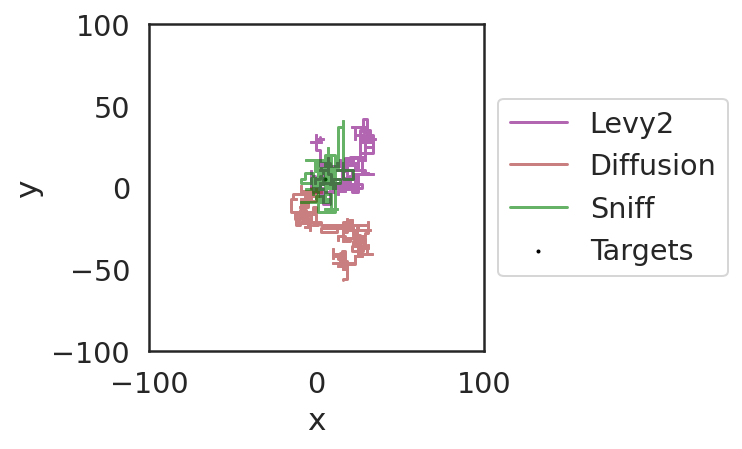

In [9]:
# Experiment settings
num_experiments = 100
num_steps = 1000
p_neg = 1
p_pos = 0
scent_sigma = 10

#agent alternates btwn sensing and moving -> uses info during sensing phase to decide whether to change orientation/direction

# Env
detection_radius = 1
min_length = 1
max_length = 10

env = ScentGrid(mode="discrete")
boundary = (100, 100)
target = (5,5)
coord, scent = create_grid_scent(boundary, amplitude=1, sigma=scent_sigma)
env.add_scent(target, 1, coord, scent)
# TODO plot scent

# Agents
diff = DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)
sniff = GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=p_neg, p_pos=p_pos)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# Run Sims
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

plot_boundary = (100, 100)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
) 

print(f'Levy - {np.sum(select_exp(levy2_exp, num_experiment)["exp_reward"])}')
print(f'Diff - {np.sum(select_exp(diff_exp, num_experiment)["exp_reward"])}')
print(f'Sniff - {np.sum(select_exp(sniff_exp, num_experiment)["exp_reward"])}')

### Question 5 [10 pts]

Was your hypothesis correct? Compare the scores to those achieved in lab.

Yes - setting p pos to 0 increased the amount of reward the sniff agent obtained by 9x (in lab obtained 8; in homework obtained 72). The Levy agent also gained more reward through this choice (2 in homework compared with 0 in lab). Diffusion agent reward obtained didn't change. 

### Question 6 [5 pts]

Can you imagine a situation in which setting _p pos_ to zero would be bad?  As in, could there exist an environment in which always strictly following the scent gradient is suboptimal? Use your imagination.

If it is just the agent and reward in the environment, then I think it will usually be benefical to the agent for p pos to be 0. If you introduce another being into the environment (e.g., predator or competitor), it might be harmful to the agent since that being will also be attracted to the reward and thus the agent. The agent might also exhaust the supply of reward present in the environment faster if p pos is 0 since simulation showed it gets a lot lot of reward (but since goal is just to survive, probably doesn't need that much).

## Submission

**DUE:** 5pm EST, Oct 12, 2021. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> Joseph Luetkehans